In [ ]:
import torch
import numpy
import pyro
import pyro.distributions as dist
import arviz as az

import sys
sys.path.append('../_mdofPINN/')
sys.path.append('../')
from pinnModels import mdof_stoch_pinn, gen_ndof_cantilever, nonlinearity

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

def sort_data(vec2sort: torch.Tensor, *data_: tuple[torch.Tensor,...]):
    sort_ids = torch.argsort(vec2sort)
    sorted_data_ = [None] * len(data_)
    for i, data in enumerate(data_):
        sorted_data_[i] = torch.zeros_like(data)
        if len(data.shape) > 1:
            for j in range(data.shape[1]):
                sorted_data_[i][:,j] = data[sort_ids,j].squeeze()
        else:
            sorted_data_[i] = data[sort_ids]
    if len(data_) > 1:
        return tuple(sorted_data_), sort_ids
    else:
        return sorted_data_[0], sort_ids

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# test_name = 'sr_vandpd_2dof_fn_snr20'
test_name = '20240820__sr_vandpd_2dof_fn_snr20'
# test_name = 'sr_fullnln_2dof_fn_snr20_short'
# test_name = '20240829__sr_fullnln_2dof_fn_snr20'
checkpoint = torch.load(f'checkpoints/{test_name}.pth')

pinn_config = checkpoint['pinn_config']
data_config = checkpoint['data_config']
ground_truth = checkpoint['ground_truth']
dataset = checkpoint['dataset']
mdof_model_dict = checkpoint['model']
train_loader = checkpoint['train_loader']
prediction = checkpoint['prediction']
alphas = checkpoint['alphas']
pinn_nonlinearity = checkpoint['pinn_nonlinearity']
n_dof = pinn_config['n_dof']
true_params = checkpoint['true_params']

mdof_model = mdof_stoch_pinn(pinn_config)
for net, state_dict in zip(mdof_model.nets, checkpoint['net_states']):
    net.load_state_dict(state_dict)
# mdof_model.set_aux_funcs(gen_ndof_cantilever, pinn_nonlinearity)
mdof_model.load_state_dict(mdof_model_dict)

match checkpoint['parser'].nonlin_type:
    case 'exponent_damping':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 0.5)
    case 'vanDerPol_damping':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 'vdp')
    case 'duffing_stiffness':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = 3, gc_exp = None)
mdof_model.set_aux_funcs(gen_ndof_cantilever, pinn_nonlinearity)

# mdof_model = torch.load('models/sr_fullnln_6dof_f1_snr25.pth')
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.plot(np.array(checkpoint['loss'])[:, -1])
# ax.set_yscale('symlog')
# ax.set_xlim(0, 5000)

$$
\theta_s = \left\{ \mathbf{c}, \mathbf{k}, k_n \right\}
$$

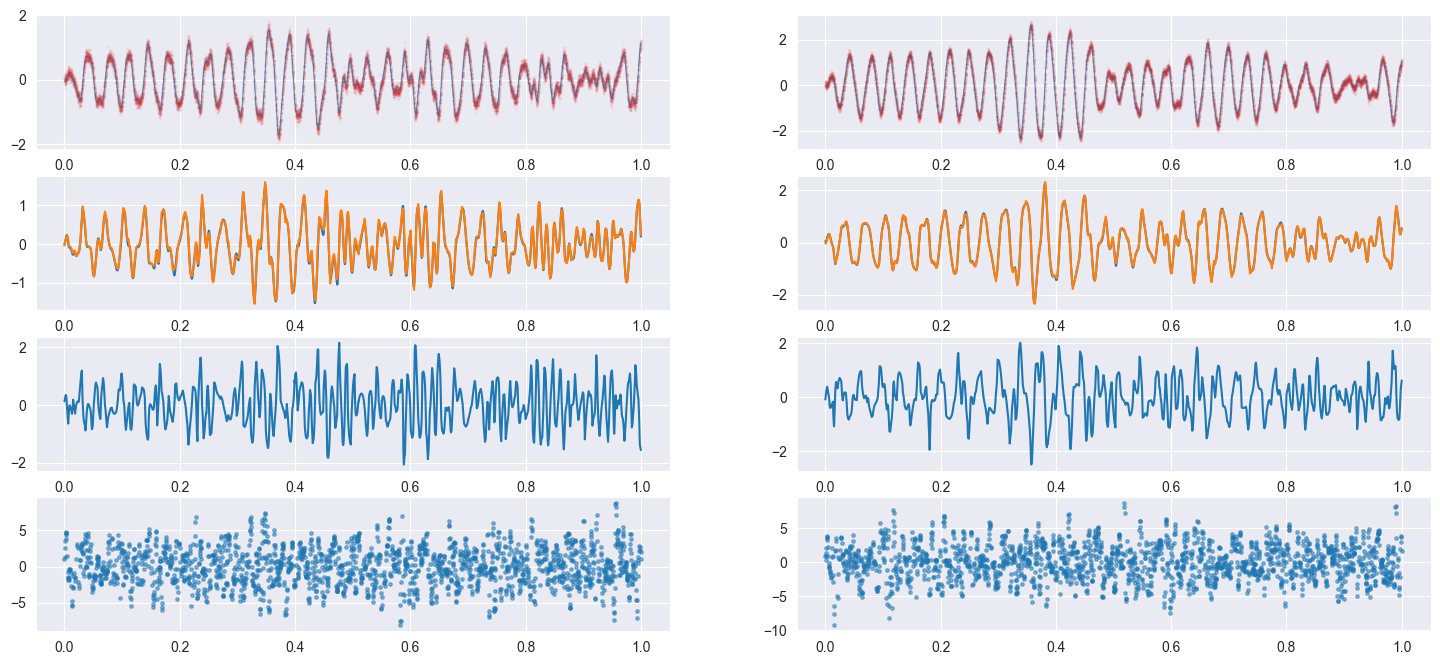

In [51]:
device = torch.device('cpu')
n_dof = pinn_config['n_dof']
n_repeats = 5

subsample = 2
cleave = 1
col_step = (data_config['batch_size'] * data_config['seq_len']) // subsample

num_col_samps = prediction['t_hat'].shape[0] // subsample

t_pred = torch.zeros((num_col_samps, 1))
z_pred = torch.zeros((num_col_samps, 2*n_dof))
dzdt_pred = torch.zeros((num_col_samps, 2*n_dof))
f_col = torch.zeros((num_col_samps, n_dof))

# parse predicted data
inpoint_ = 0
outpoint_ = col_step * subsample

for i, (obs_data, _) in enumerate(train_loader):
    
    # if (i) % subsample != 0:
    #     continue
    # elif i != 0:
    #     inpoint_ += col_step * subsample
    #     outpoint_ += col_step * subsample
    
    # t_col_ = [obs_data[:, 0, nq, -1].reshape(-1, 1).requires_grad_() for nq in range(data_config['seq_len'])]
    # force_obs_ = [obs_data[:, 0, nq, 2*n_dof:-1].reshape(-1, n_dof).float().to(device) for nq in range(data_config['seq_len'])]

    inpoint_ = i * col_step
    outpoint_ = (i + 1) * col_step
    
    t_col_ = [obs_data[::subsample, 0, nq, -1].reshape(-1, 1).requires_grad_() for nq in range(data_config['seq_len'])]
    force_obs_ = [obs_data[::subsample, 0, nq, 2*n_dof:-1].reshape(-1, n_dof).float().to(device) for nq in range(data_config['seq_len'])]
    
    z_pred_, _, t_pred_, dzdt_pred_, f_col_ = mdof_model.predict(t_col_, theta_s=None, f_col=force_obs_)
    t_pred[inpoint_:outpoint_] = t_pred_.reshape(-1, 1)
    z_pred[inpoint_:outpoint_, :] = z_pred_.reshape(-1, 2*n_dof)
    dzdt_pred[inpoint_:outpoint_, :] = dzdt_pred_.reshape(-1, 2*n_dof)
    f_col[inpoint_:outpoint_, :] = f_col_.reshape(-1, n_dof)

(z_pred, f_col, t_pred, dzdt_pred), _ = sort_data(t_pred[:,0], z_pred, f_col, t_pred, dzdt_pred)
t_pred = t_pred[:num_col_samps//cleave, :].detach()
z_pred = z_pred[:num_col_samps//cleave, :].detach()
dzdt_pred = dzdt_pred[:num_col_samps//cleave, :].detach()
f_col = f_col[:num_col_samps//cleave, :].detach()

mdof_model.t_pred = t_pred
mdof_model.z_pred = z_pred
mdof_model.dzdt_pred = dzdt_pred
mdof_model.f_col = f_col

fig, axs = plt.subplots(4, n_dof, figsize=(18, 8))

for dof in range(n_dof):
    axs[0, dof].scatter(dataset.obs_data[:, :, :, -1], dataset.obs_data[:, :, :, dof] * alphas["x"].item(), s=1, c='tab:red', alpha=0.05)
    axs[0, dof].plot(mdof_model.t_pred.detach(), mdof_model.z_pred[:, dof].detach() * alphas["x"].item(), linewidth=0.5)
    # axs[0, dof].plot(mdof_model.z_pred[:, dof].detach() * alphas["x"].item(), linewidth=0.5)

    axs[1, dof].plot(mdof_model.t_pred.detach(), mdof_model.z_pred[:, dof + n_dof].detach() * alphas["v"].item())
    axs[1, dof].plot(mdof_model.t_pred.detach(), mdof_model.dzdt_pred[:, dof].detach() * alphas["x"].item()/alphas["t"].item())

    axs[2, dof].plot(mdof_model.t_pred.detach(), mdof_model.dzdt_pred[:, dof + n_dof].detach() * alphas["v"].item()/alphas["t"].item())

    axs[3, dof].scatter(mdof_model.t_pred.detach(), mdof_model.f_col[:, dof].detach() * dataset.alphas["f"].item(), s=6, marker='o', alpha=0.5)
    # axs[3, dof].plot(mdof_model.f_col[:, dof].detach() * dataset.alphas["f"].item(), marker='o', alpha=0.5)
    # axs[3, dof].set_xlim([0, 0.01])
    # axs[3, dof].set_ylim([-0.0, 0.3])

In [ ]:
device = torch.device('cpu')
n_dof = pinn_config['n_dof']
n_repeats = 5

# num_col_samps = 1024
subsample = 4
col_step = (data_config['batch_size'] * n_repeats * data_config['seq_len'])//subsample

num_col_samps = prediction['t_hat'].shape[0]//subsample

t_pred = torch.zeros((num_col_samps * n_repeats, 1))
z_pred = torch.zeros((num_col_samps * n_repeats, 2*n_dof))
dzdt_pred = torch.zeros((num_col_samps * n_repeats, 2*n_dof))
f_col = torch.zeros((num_col_samps * n_repeats, n_dof))

# parse predicted data

for i, (obs_data, _) in enumerate(train_loader):

    inpoint_ = i * col_step
    outpoint_ = (i + 1) * col_step
    t_col_ = [obs_data[::subsample, :, nq, -1].reshape(-1, 1).requires_grad_() for nq in range(data_config['seq_len'])]
    force_obs_ = [obs_data[::subsample, :, nq, 2*n_dof:-1].reshape(-1, n_dof).float().to(device) for nq in range(data_config['seq_len'])]
    z_pred_, _, t_pred_, dzdt_pred_, f_col_ = mdof_model.predict(t_col_, theta_s=None, f_col=force_obs_)
    t_pred[inpoint_:outpoint_] = t_pred_.reshape(-1, 1)
    z_pred[inpoint_:outpoint_, :] = z_pred_.reshape(-1, 2*n_dof)
    dzdt_pred[inpoint_:outpoint_, :] = dzdt_pred_.reshape(-1, 2*n_dof)
    f_col[inpoint_:outpoint_, :] = f_col_.reshape(-1, n_dof)

(z_pred, f_col, t_pred, dzdt_pred), _ = sort_data(t_pred[:,0], z_pred, f_col, t_pred, dzdt_pred)
z_pred = z_pred.detach()
dzdt_pred = dzdt_pred.detach()
f_col = f_col.detach()

mdof_model.t_pred = t_pred
mdof_model.z_pred = z_pred
mdof_model.dzdt_pred = dzdt_pred
mdof_model.f_col = f_col

fig, axs = plt.subplots(4, n_dof, figsize=(18, 8))

for dof in range(n_dof):
    axs[0, dof].scatter(dataset.obs_data[:, :, :, -1], dataset.obs_data[:, :, :, dof] * alphas["x"].item(), s=1, c='tab:red', alpha=0.05)
    axs[0, dof].plot(mdof_model.t_pred.detach(), mdof_model.z_pred[:, dof].detach() * alphas["x"].item(), linewidth=0.5)
    # axs[0, dof].plot(mdof_model.z_pred[:, dof].detach() * alphas["x"].item(), linewidth=0.5)

    axs[1, dof].plot(mdof_model.t_pred.detach(), mdof_model.z_pred[:, dof + n_dof].detach() * alphas["v"].item())
    axs[1, dof].plot(mdof_model.t_pred.detach(), mdof_model.dzdt_pred[:, dof].detach() * alphas["x"].item()/alphas["t"].item())

    axs[2, dof].plot(mdof_model.t_pred.detach(), mdof_model.dzdt_pred[:, dof + n_dof].detach() * alphas["v"].item()/alphas["t"].item())

    axs[3, dof].scatter(mdof_model.t_pred.detach(), mdof_model.f_col[:, dof].detach() * dataset.alphas["f"].item(), s=6, marker='o', alpha=0.5)
    # axs[3, dof].plot(mdof_model.f_col[:, dof].detach() * dataset.alphas["f"].item(), marker='o', alpha=0.5)
    # axs[3, dof].set_xlim([0, 0.01])
    # axs[3, dof].set_ylim([-0.0, 0.3])

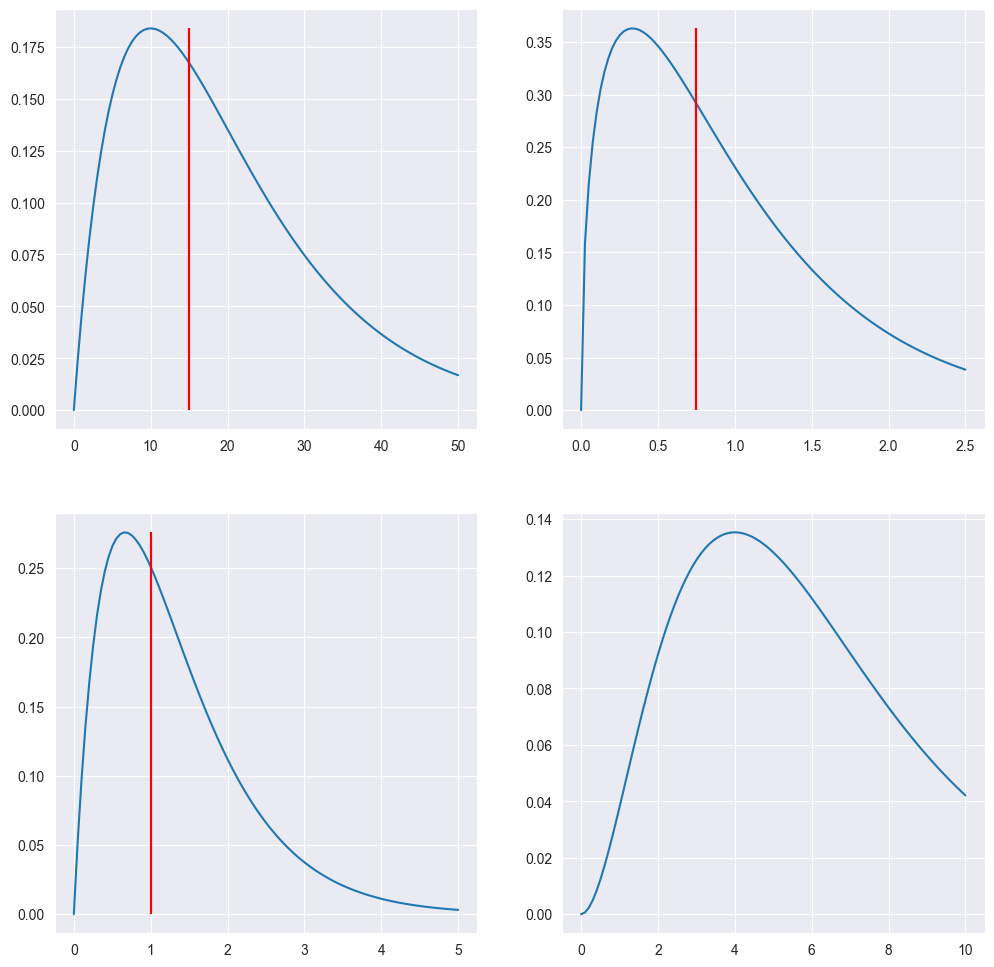

In [52]:
# set priors

def gamma_from_mean_and_var(mean, var):
    alpha = mean**2 / var
    beta = mean / var
    return dist.Gamma(alpha, beta)

def update_pinn_sys_norms(pinn_model, alphas):
    pinn_model.config['alphas'].update(alphas)
    pinn_model.config['phys_params'].update({
        'k_': {
            'type': 'variable',
            'value': torch.ones(n_dof)
        },
        'kn_': {
            'type': 'variable',
            'value': torch.ones(n_dof)
        },
        'c_': {
            'type': 'variable',
            'value': torch.ones(n_dof)
        },
    })
    pinn_model.set_norm_params()

alphas.update({
    'k': torch.tensor([5.0]),
    'kn': torch.tensor([20.0]),
    'c': torch.tensor([0.5]),
    'cn': torch.tensor([0.5]),
    'sigma': torch.tensor([1.0e-1]),
    'm': torch.tensor([1.0])
})

# update_pinn_sys_norms(mdof_model, alphas)

# k_dist = dist.Normal(torch.tensor([4.0]), torch.tensor([4.0]))
# kn_dist = dist.Normal(torch.tensor([3.0]), torch.tensor([0.01]))
# c_dist = dist.Normal(torch.tensor([1.5]), torch.tensor([2.0]))
# cn_dist = dist.Normal(torch.tensor([1.0]), torch.tensor([2.0]))
# sigma_dist = dist.Gamma(torch.tensor([3.0]), torch.tensor([0.5]))

k_dist = dist.Gamma(torch.tensor([2.0]), torch.tensor([0.5]))
kn_dist = dist.Gamma(torch.tensor([3.0]), torch.tensor([0.5]))
c_dist = dist.Gamma(torch.tensor([2.0]), torch.tensor([0.75]))
cn_dist = dist.Gamma(torch.tensor([1.5]), torch.tensor([0.75]))
sigma_dist = dist.Gamma(torch.tensor([3.0]), torch.tensor([0.5]))

k_vec = torch.linspace(0, 10, 100)
c_vec = torch.linspace(0, 10, 100)
kn_vec = torch.linspace(0, 10, 100)
cn_vec = torch.linspace(0, 5, 100)
sigma_vec = torch.linspace(0, 10, 100)

# k_dist = gamma_from_mean_and_var(torch.tensor([4.0]), torch.tensor([5.0]))
# kn_dist = gamma_from_mean_and_var(torch.tensor([2.5]), torch.tensor([3.0]))
# c_dist = dist.Gamma(torch.tensor([4.0]), torch.tensor([1.0]))
# sigma_dist = dist.HalfNormal(torch.tensor([1.0e-1]))

# k_vec = torch.linspace(0, 1e3, 100) / alphas['k']
# c_vec = torch.linspace(0, 10, 100) / alphas['c']
# kn_vec = torch.linspace(0, 5e3, 100) / alphas['kn']
# sigma_vec = torch.linspace(0.0, 10e-2, 100)

k_pdf = torch.exp(k_dist.log_prob(k_vec))
c_pdf = torch.exp(c_dist.log_prob(c_vec))
kn_pdf = torch.exp(kn_dist.log_prob(kn_vec))
cn_pdf = torch.exp(cn_dist.log_prob(cn_vec))
sigma_pdf = torch.exp(sigma_dist.log_prob(sigma_vec))

pdfs = [[c_vec, c_pdf]] * 2 + [[k_vec, k_pdf]] * 2 + [[kn_vec, kn_pdf]] * 2 + [[sigma_vec, sigma_pdf]]

fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0,0].plot(k_vec * alphas['k'], k_pdf)
axs[0,0].vlines(true_params['k_'], 0.0, torch.max(k_pdf), color='red')
if (test_name[3:10] == 'fullnln') | (test_name[13:20] == 'fullnln'):
    axs[0,1].plot(kn_vec * alphas['kn'], kn_pdf)
    axs[0,1].vlines(true_params['kn_'], 0.0, torch.max(kn_pdf), color='red')
elif (test_name[3:10] == 'vandpd_') | (test_name[13:20] == 'vandpd_'):
    axs[0,1].plot(cn_vec * alphas['cn'], cn_pdf)
    axs[0,1].vlines(true_params['cn_'], 0.0, torch.max(cn_pdf), color='red')
axs[1,0].plot(c_vec * alphas['c'], c_pdf)
axs[1,0].vlines(true_params['c_'], 0.0, torch.max(c_pdf), color='red')
axs[1,1].plot(sigma_vec, sigma_pdf)

In [53]:
def model(observations):
    theta_s = torch.zeros(3*n_dof+1)
    for i in range(n_dof):
        theta_s[i] = pyro.sample(f'c{i}', c_dist)
        theta_s[n_dof+i] = pyro.sample(f'k{i}', k_dist)
        if (test_name[3:10] == 'fullnln') | (test_name[13:20] == 'fullnln'):
            theta_s[2*n_dof+i] = pyro.sample(f'kn{i}', kn_dist)
        else:
            theta_s[2*n_dof+i] = pyro.sample(f'cn{i}', kn_dist)
    theta_s[-1] = pyro.sample('sigma_f', sigma_dist)

    f_pred = mdof_model.locked_force_pred(theta_s, z_pred, dzdt_pred)

    return pyro.sample('f_pred', dist.Normal(loc=f_pred, scale=theta_s[-1]), obs=observations)

observations = mdof_model.f_col

nuts_kernel = pyro.infer.NUTS(
    model,
    jit_compile=True,
    target_accept_prob=0.9,
    # adapt_step_size=False,
    # step_size=8.0e-4
    )
mcmc = pyro.infer.MCMC(nuts_kernel,
    num_samples=5000,
    warmup_steps=5000,
    num_chains=1,
    # initial_params = {
    #     'c0': torch.tensor(1.0),
    #     'c1': torch.tensor(1.0),
    #     'k0': torch.tensor(1.0),
    #     'k1': torch.tensor(1.0),
    #     'kn0': torch.tensor(5.0),
    #     'kn1': torch.tensor(5.0),
    #     'sigma_f': torch.tensor(1.0e-1)
    # }
    )
mcmc.run(
    observations = observations
    )

Sample: 100%|██████████| 10000/10000 [03:31, 47.33it/s, step size=2.30e-01, acc. prob=0.911]


In [55]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
# labels = [f'c{i}' for i in range(n_dof)] + [f'k{i}' for i in range(n_dof)] + [f'kn{i}' for i in range(n_dof)] + ['sigma_f']
labels = [f'c{i}' for i in range(n_dof)] + [f'k{i}' for i in range(n_dof)] + [f'cn{i}' for i in range(n_dof)] + ['sigma_f']
xsamp = np.hstack( tuple(hmc_samples[label].reshape(-1,1) for label in labels) )
# alphas_vec = [alphas[f'{label[:-1]}_'] for label in labels[:-1]]
# alphas_vec.append(alphas['sigma_'])
# alphas_vec = np.array(alphas_vec)

means = np.mean(xsamp, axis=0)
# for i, lab in enumerate(labels):
#     print(f'mean for param {lab}: {means[i]:.4f}')

# diagnostics_ = mcmc.diagnostics()
mcmc.summary(0.9)
posterior_samples = mcmc.get_samples()
posterior_predictive = pyro.infer.Predictive(model, posterior_samples)(observations)
prior = pyro.infer.Predictive(model, num_samples=500)(observations)

mcmc_arviz = az.from_pyro(
    mcmc,
    prior = prior,
    posterior_predictive = posterior_predictive,
    coords={'param': labels},
    dims={'theta': ['param']},
    )

torch.save(mcmc_arviz, f'hmc_samples/{test_name}_mcmc_model.pth')
torch.save(hmc_samples, f'hmc_samples/{test_name}_hmc_samples.pth')


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     c0[0]      1.05      0.11      1.05      0.87      1.22   2265.16      1.00
     c1[0]      1.00      0.13      0.99      0.78      1.21   2114.96      1.00
    cn0[0]      0.72      0.13      0.72      0.50      0.93   2402.12      1.00
    cn1[0]      0.79      0.16      0.78      0.53      1.04   2150.69      1.00
     k0[0]     14.92      0.06     14.92     14.82     15.02   3921.65      1.00
     k1[0]     14.85      0.06     14.85     14.74     14.94   4068.18      1.00
sigma_f[0]      0.08      0.00      0.08      0.07      0.08   4821.16      1.00

Number of divergences: 0


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


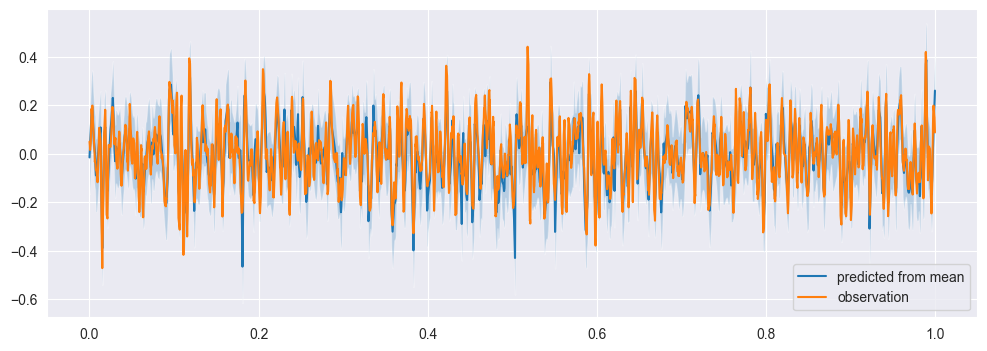

In [56]:
f_pred = mdof_model.locked_force_pred(torch.tensor(means), z_pred, dzdt_pred)
# true_params = torch.tensor([1.0, 1.0, 15.0, 15.0, 100.0, 1e-3])
true_params_vec = np.concatenate((true_params['c_'], true_params['k_'], true_params['kn_'], np.array([1e-3])))
f_pred_2 = mdof_model.locked_force_pred(torch.tensor(true_params_vec, dtype=torch.float32), z_pred, dzdt_pred)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(mdof_model.t_pred.detach(), f_pred.detach()[:,-1], label='predicted from mean')
# ax.plot(mdof_model.t_pred.detach(), f_pred_2.detach()[:,-1], label='predicted from true')
ax.plot(mdof_model.t_pred.detach(), f_col.detach()[:,-1]*alphas['f'].item()/alphas['f'].item(), label='observation')
ax.fill_between(mdof_model.t_pred.detach().reshape(-1), f_pred.detach()[:,-1] - 2 * means[-1], f_pred.detach()[:,-1] + 2 * means[-1], alpha=0.25)
ax.legend()
# ax.set_ylim((-3, 3))

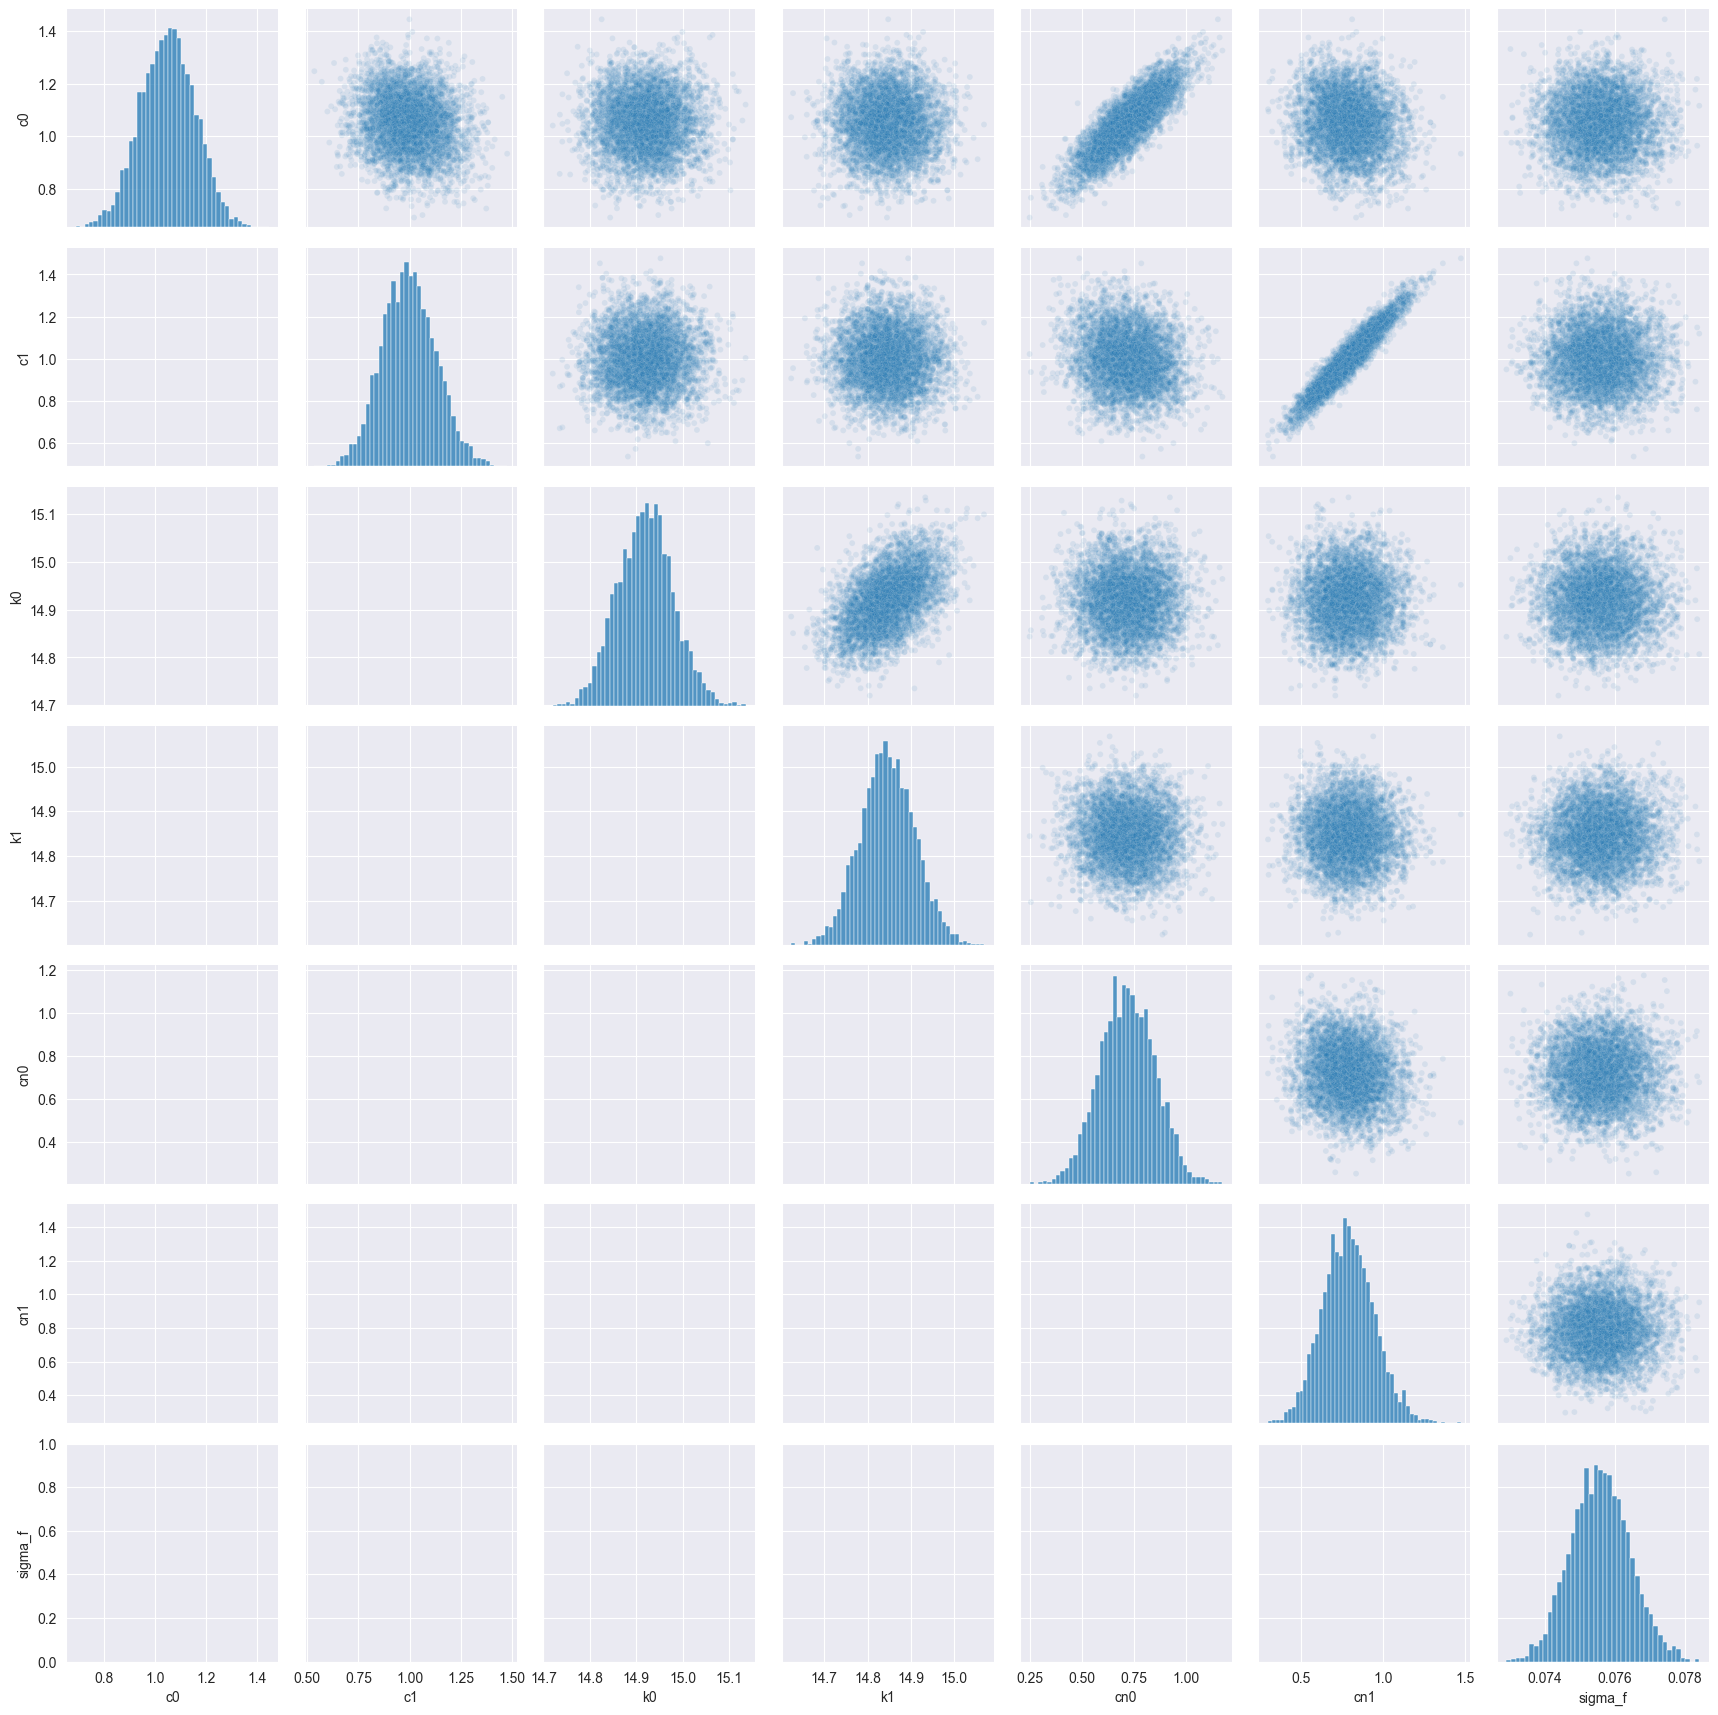

In [57]:
xsamp_df = pd.DataFrame(xsamp[:,:], columns=labels)

sns.set_style('darkgrid')
sns_grid = sns.PairGrid(xsamp_df)
sns_grid.map_diag(sns.histplot, stat='probability')
sns_grid.map_upper(sns.scatterplot, size=5, alpha=0.1)
# for n in range(2 * n_dof + 1):
    # sns_grid.axes[n, n].plot(pdfs[n][0], pdfs[n][1])
    # sns_grid.axes[n, n].set_xlim((0, true_params[n] * 2))
# sns_grid.map_lower(sns.kdeplot, fill=True, cmap="Blues")